In [11]:
#Imports set up
import torch
import zipfile
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time, os


In [12]:
# Data preparation
zip_path = "/content/sample_data/archive.zip"
data_dir = "/content/extracted_data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                             shuffle=True, num_workers=2)
               for x in ['train', 'val']}

class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [17]:
# Pretrained model loading
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False  # freeze layers

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # binary classification
model = model.to(device)


In [14]:
# Loss and Optimizer definition
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [15]:
# Loop training
def train_model(model, criterion, optimizer, num_epochs=5):
    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, train_losses, val_losses, train_acc, val_acc

model, train_losses, val_losses, train_acc, val_acc = train_model(model, criterion, optimizer, num_epochs=5)


Epoch 1/5
----------
train Loss: 0.7015 Acc: 0.5891
val Loss: 0.5511 Acc: 0.7429
Epoch 2/5
----------
train Loss: 0.4472 Acc: 0.8618
val Loss: 0.3819 Acc: 0.8286
Epoch 3/5
----------
train Loss: 0.2916 Acc: 0.9236
val Loss: 0.2782 Acc: 0.9571
Epoch 4/5
----------
train Loss: 0.2263 Acc: 0.9564
val Loss: 0.2266 Acc: 0.9714
Epoch 5/5
----------
train Loss: 0.1960 Acc: 0.9418
val Loss: 0.1890 Acc: 0.9571


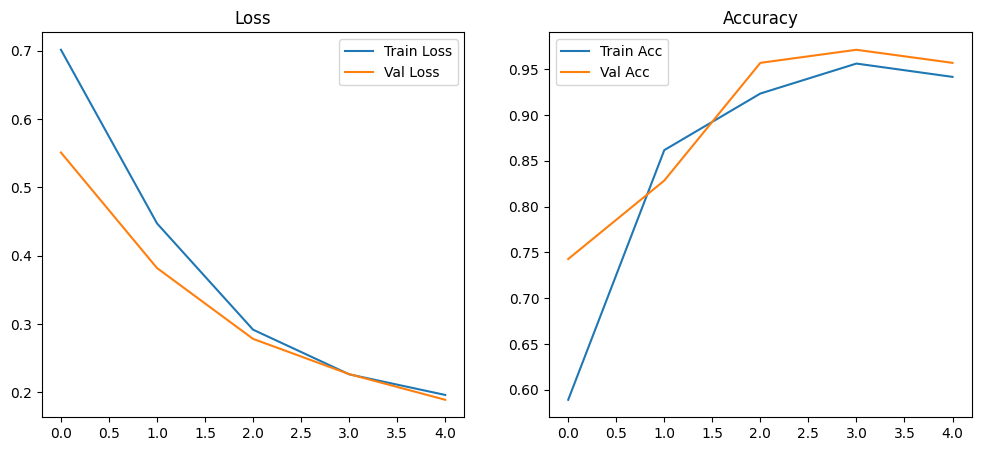

In [18]:
# Results plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()


In [23]:
from PIL import Image
import torchvision.transforms as transforms

torch.save(model.state_dict(), 'binary_classifier.pth')

def predict_image(image_path):
    model.eval()
    img = Image.open(image_path)
    transform = data_transforms['val']
    img_t = transform(img).unsqueeze(0).to(device)

    outputs = model(img_t)
    _, pred = torch.max(outputs, 1)
    print(f"Predicted: {class_names[pred.item()]}")

In [27]:
#QA
predict_image("/content/csm_schwarzer_Hund_auf_Wiese_c_xkunclova-Shutterstock_01_5566a80d25.webp")
predict_image("/content/NationalGeographic_2572187_16x9.avif")

Predicted: dog
Predicted: cat
